In [ ]:
from collections import defaultdict
import numpy as np
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [ ]:
class NaiveBayesClassifier(object):
    def fit(self, X, y, epsilon=1e-10):
        self.y_classes, y_counts = np.unique(y, return_counts=True)
        self.x_classes = np.array([np.unique(x) for x in X.T], dtype=object)
        self.u = np.array([X[y == k].mean(axis=0) for k in self.y_classes]) #матожидания для каждого класса
        self.var_x = np.array([X[y == k].var(axis=0) + epsilon for k in self.y_classes]) #дисперсия для каждого класса
        return self

    def predict(self, X):
        return np.apply_along_axis(lambda x: self.compute_probs(x), 1, X)

    def compute_probs(self, x):
        probs = np.array([self.compute_prob(x, y) for y in range(len(self.y_classes))]) #условная вероятность встречи признака для каждого класса
        return self.y_classes[np.argmax(probs)]

    def compute_prob(self, x, y):
        c = 1.0 / np.sqrt(2.0 * np.pi * self.var_x[y])
        return np.prod(c * np.exp(-1.0 * np.square(x - self.u[y]) / (2.0 * self.var_x[y]))) #формула распределения вероятности

    def evaluate(self, X, y):
        return (self.predict(X) == y).mean()

In [ ]:
N = 220
noise = np.random.randn(N, 2)
cloud1 = noise + np.array([4, 4])
cloud2 = noise + np.array([5, 7])
cloud3 = noise + np.array([6, 9])
data = np.vstack([cloud1, cloud2, cloud3])

In [ ]:
annotation1 = [0]*N
annotation2 = [1]*N
annotation3 = [2]*N
annotations = annotation1 + annotation2 + annotation3

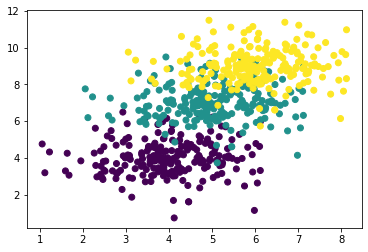

In [ ]:
plt.scatter(data[:,0], data[:,1], c=annotations)

In [ ]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(data, annotations, test_size=0.25)

In [ ]:
Xtrain.shape, Xtest.shape

((495, 2), (165, 2))

In [ ]:
len(Ytrain), len(Ytest)

(495, 165)

In [ ]:
def evaluate(P, T):
    # P - predictions
    # T - targets
    # accuracy = correct predictions / all predictions
    # ---
    # P - предсказания
    # T - метки
    # точность = (количество корректных предсказаний) / (количество всех предсказаний)
    accuracy = np.mean(P == T)
    return accuracy

1) Сравнение классификаторов

In [ ]:
classifers_info = []
for model in [NaiveBayesClassifier(), GaussianNB(), MultinomialNB(), ComplementNB(), BernoulliNB()]:
  model.fit(Xtrain, Ytrain)
  pred = model.predict(Xtest)
  conf_mat = confusion_matrix(Ytest, pred)
  print(type(model).__name__ + "\n", conf_mat)
  accuracy = evaluate(model.predict(Xtest), Ytest)
  print(accuracy*100, '%')
  #подсчет времени на классификацию по одному
  arr_one = []
  for i in range(len(Xtest) - 1):
    start_time = time.time()
    model.predict(Xtest[i:i + 1])
    end_time = time.time()
    arr_one.append(end_time - start_time)
  #sns.heatmap(conf_mat, annot=True)
  #подсчет времени на классфикацию по всей выборке 100 раз (типо стресстест такой)
  
  arr_full = []
  for i in range(100):
    tmp_test = shuffle(Xtest)
    start_time = time.time()
    model.predict(tmp_test)
    end_time = time.time()
    arr_full.append(end_time - start_time)

  classifers_info.append((type(model).__name__, accuracy, arr_one[0], np.var(arr_one), conf_mat, np.mean(arr_full), np.var(arr_full)))

print(classifers_info)

NaiveBayesClassifier
 [[49  3  0]
 [ 3 49  5]
 [ 0  8 48]]
88.48484848484848 %
GaussianNB
 [[49  3  0]
 [ 3 49  5]
 [ 0  8 48]]
88.48484848484848 %
MultinomialNB
 [[41  3  8]
 [16 21 20]
 [ 7 11 38]]
60.60606060606061 %
ComplementNB
 [[44  0  8]
 [26  0 31]
 [15  0 41]]
51.515151515151516 %
BernoulliNB
 [[52  0  0]
 [57  0  0]
 [56  0  0]]
31.515151515151512 %
[('NaiveBayesClassifier', 0.8848484848484849, 0.0002300739288330078, 3.130273982462907e-08, array([[49,  3,  0],
       [ 3, 49,  5],
       [ 0,  8, 48]]), 0.008776113986968995, 1.126691546880352e-05), ('GaussianNB', 0.8848484848484849, 0.0001728534698486328, 1.2752891329647118e-08, array([[49,  3,  0],
       [ 3, 49,  5],
       [ 0,  8, 48]]), 0.00015149354934692382, 2.555419712280127e-10), ('MultinomialNB', 0.6060606060606061, 9.799003601074219e-05, 3.541650177571598e-11, array([[41,  3,  8],
       [16, 21, 20],
       [ 7, 11, 38]]), 6.53529167175293e-05, 1.0849009299818133e-10), ('ComplementNB', 0.5151515151515151, 0.0001

2) Классификатор наиболее точный

In [ ]:
max(classifers_info, key = lambda x: x[1])[0]

'NaiveBayesClassifier'

3) Гистограммы производительности классификаторов по 1 точке

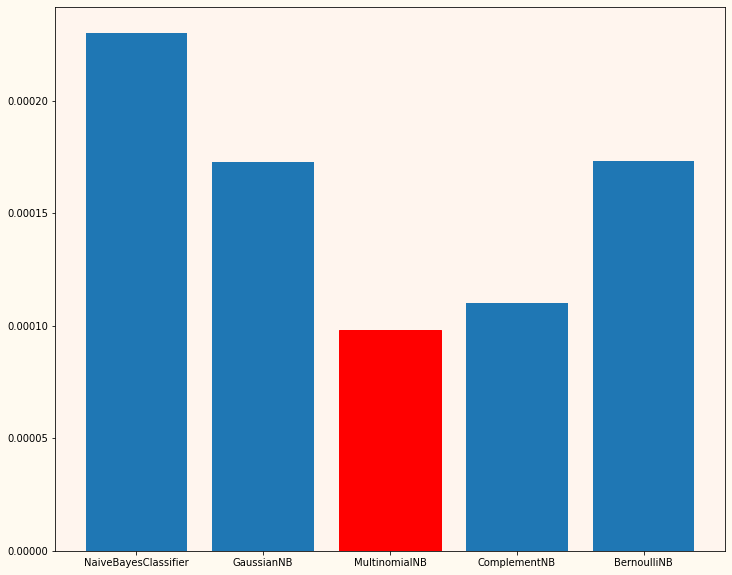

In [ ]:
x = [i[0] for i in classifers_info]
y = [n[2] for n in classifers_info]

fig, ax = plt.subplots()

mn = min(classifers_info, key = lambda x: x[2])[0]
idx = x.index(mn)
barlist = ax.bar(x, y)
barlist[idx].set_color('r')

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)
fig.set_figheight(10)

plt.show()

4) наиболее стабильный классификатор (дисперсия при классификации по одной точке)

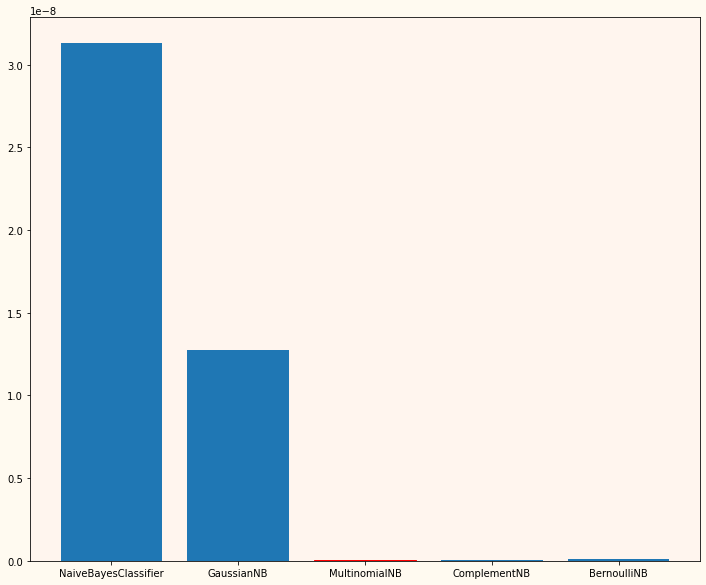

In [ ]:
x = [i[0] for i in classifers_info]
y = [n[3] for n in classifers_info]

fig, ax = plt.subplots()

mn = min(classifers_info, key = lambda x: x[3])[0]
idx = x.index(mn)
barlist = ax.bar(x, y)
barlist[idx].set_color('r')

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)
fig.set_figheight(10)

plt.show()


In [ ]:
mn

'MultinomialNB'

5) Гистограмма среднего времени классификации по всей тестовой выборке по 100 раз. Видно, что моя реализация работает значительно медленнее при увеличении размера входных данных. Критерием более достоверной оценки стабильности производительности может быть некая функция от размера тестовой выборки, потому что в большинстве случаев нам надо классифицировать много элементов сразу, а не один.

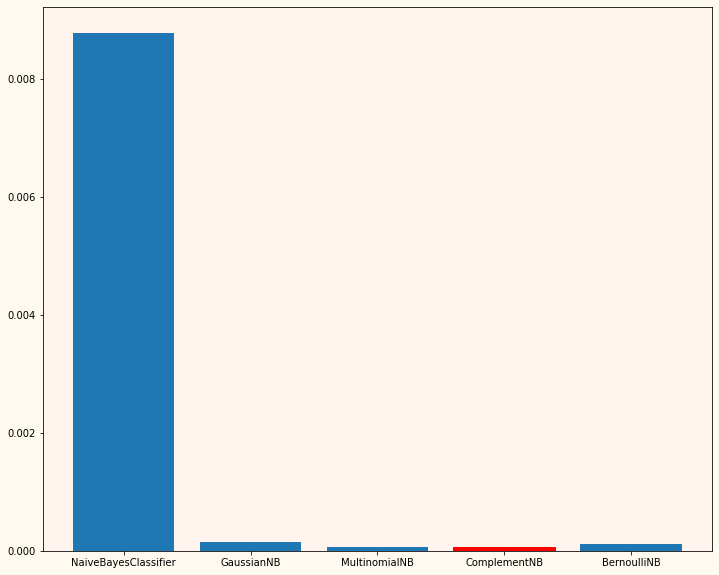

In [ ]:
x = [i[0] for i in classifers_info]
y = [n[5] for n in classifers_info]

fig, ax = plt.subplots()

mn = min(classifers_info, key = lambda x: x[5])[0]
idx = x.index(mn)
barlist = ax.bar(x, y)
barlist[idx].set_color('r')

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)
fig.set_figheight(10)

plt.show()

Дисперсия времени при классификации одной перемешанной выборки 100 раз

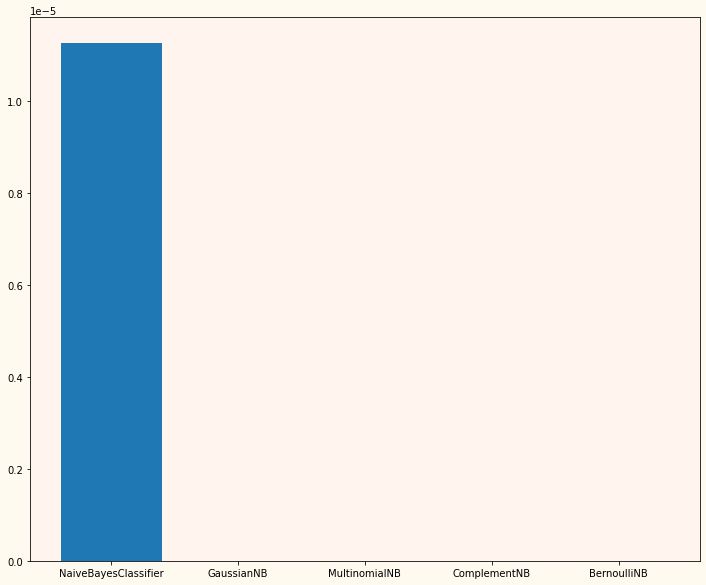

In [ ]:
x = [i[0] for i in classifers_info]
y = [n[6] for n in classifers_info]

fig, ax = plt.subplots()

mn = min(classifers_info, key = lambda x: x[6])[0]
idx = x.index(mn)
barlist = ax.bar(x, y)
barlist[idx].set_color('r')

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)
fig.set_figheight(10)

plt.show()

Наиболее стабильный классификатор по моей оценке:

In [ ]:
min(classifers_info, key = lambda x: x[5])[0]

'ComplementNB'